--------------------------------------------------------------------------------
***Niloufar Abbasi***

***401209996***

--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
# ***Supervised Forward-Forward Algorithm:***
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

## **Required Libraries:**

In [1]:
#required libraries:

import matplotlib.pyplot as plt
import numpy             as np
import os
import torch
import torchvision
import copy
import time
#-----------------------------------------------
from scipy.signal           import convolve2d
from sklearn.metrics        import accuracy_score
#-----------------------------------------------
from torch                  import nn
from torch                  import tensor
from torch                  import Tensor
from torch.optim            import Adam
from torch.optim            import Optimizer
from torch.utils.data       import DataLoader
from torch.utils.data       import Dataset
from torch.utils.data       import Subset
from torchvision            import datasets
from torchvision.datasets   import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import Lambda
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
from torch.nn               import Module
from torch.nn               import Linear
from torch.nn               import ReLU
from torch._jit_internal    import _copy_to_script_wrapper
#----------------------------------------------
from tqdm                   import tqdm
from typing                 import Iterator


In [2]:
torch.manual_seed(0)

-------------------------------------------------------------------------------
# **(آ)**

# ***لود کردن دیتاست***

In [3]:
def data_loaders(train_batch_size=50, test_batch_size=50):
    # data transformation pipeline
    transform = Compose([
            ToTensor()                      ,    # Convert image to tensor
            Normalize((0.1307,), (0.3081,)) ,    # Normalize the tensor with mean (0.1307) and standard deviation (0.3081)
            Lambda(lambda x: torch.flatten(x))]) # flatenning
#===================================================
    # Load training data
    training_data = datasets.MNIST(
        root      = "data"    ,                  # directory to store the dataset
        train     = True      ,                  # training set
        download  = True      ,                  # Download the dataset
        transform = transform )                  # aapply the defined transformation
#---------------------------------------------------
    # Load test data
    test_data = datasets.MNIST(
        root      = "data"    ,                  # directory to store the dataset
        train     = False     ,                  # test set
        download  = True      ,                  # download yhe dataset
        transform = transform )                  # apply the transformation
#===================================================
    # Creating DataLoader for training data
    train_loader = DataLoader(
        training_data                 ,          # This is the dataset to load
        batch_size = train_batch_size ,          # number of samples in each batch
        shuffle = True)                          # Shuffle for each epoch
#---------------------------------------------------
    # creating DataLoader for test data
    test_loader = DataLoader(
        test_data                    ,           #dataset to load
        batch_size = test_batch_size ,           # #of samples in each batch
        shuffle = False)                         # No shuffling
#===================================================
    return train_loader, test_loader             #created data Loaders

The **data_loaders** function is designed to obtain DataLoader objects for the MNIST dataset with specified batch sizes for training and testing.

1.Data Transformation pipeline:

*   *ToTensor()* converts the image data to tensors.
*   *Normalize()* normalizes the tensor values using the mean (0.1307) and standard deviation (0.3081).
*   *Lambda()* applies a lambda function to flatten the tensor.

2.The next part is about loading the MNIST datasets for training and test data.
**train=True** specifies the training set, while **train=False** specifies the test set.

3.the last part is about Creating Data Loaders. **batch_size** determines the number of samples in each batch. **shuffle=True** shuffles the data for each epoch during training.

In the end thi function returns the created DataLoader objects for training and test datasets.

In [4]:
train_loader, test_loader = data_loaders()

100%|██████████| 9912422/9912422 [00:00<00:00, 84304369.04it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 52191164.94it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54194254.48it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20617455.38it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



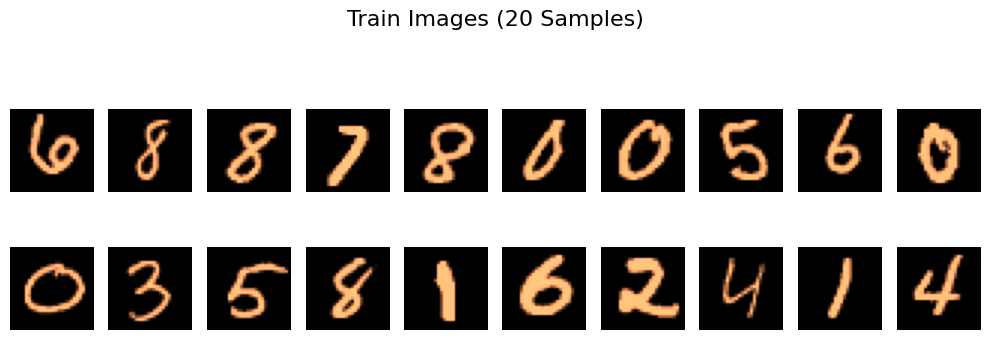

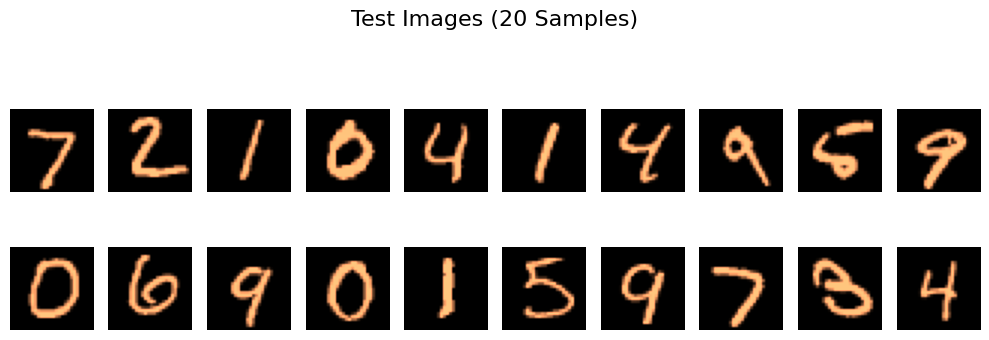

In [5]:
def show_images(images, title):
    fig, axes = plt.subplots(2, 10, figsize=(10, 4))          # a 2x10 subplot grid with figure size (10,4))
    fig.suptitle(title, fontsize=16)                          # Set the title for figure
    for i, ax in enumerate(axes.flat):                        # Iterate over the flat version of the subplot grid
        ax.imshow(images[i].reshape(28, 28), cmap='copper')   # reshaped to 28x28, using the 'copper' colormap
        ax.axis('off')                                        # tturn off axis labels for better visualization
    plt.tight_layout()                                        # Adjust layout to prevent clippping of the title
    plt.show()                                                # Display
#------------------------------------------------------------------------------
# Get a batch of 20 train images
train_images, _ = next(iter(train_loader))
train_images    = train_images[:20]
# Get a batch of 20 test images
test_images, _ = next(iter(test_loader))
test_images    = test_images[:20]
#-------------------------------------------------------------------------------
show_images(train_images, "Train Images (20 Samples)")        # Display the grid of 20 train images with "Train Images" title
print("\n\n")                                                 # Creating some space
show_images(test_images , "Test Images (20 Samples)" )        # Display the grid of 20 test images with "Test Images" title

--------------------------------------------------------------------------------

# **(ب)**

# ***تولید داده***

In [6]:
# Replace the first 10 pixels of data [x] with one-hot-encoded label [y] (as said in the question)
def put_y_on_x(x: Tensor, y: Tensor):
    x_prim = x.clone()                     # ccreate a deep copy of the input tensor to avoid mod ifying the original one
    x_prim[:, :10] *= 0.0                  #Set the first 10 pixel of each sample to 0
    x_prim[range(x.shape[0]), y] = x.max() # set the pixel corresponding to the one-hot-encoded label [y] to the maximum value in the original [x]
    return x_prim

In [7]:

x_train, y_train = next(iter(train_loader))   # extract a batch of data and labels from the training loader
x_train    = x_train.cuda()                   # Move the tensors to the GPU (assuming CUDA is available)
y_train    = y_train.cuda()                   # move the tensor to the GPU for faster processing
#-------------------------------------------------------------------------------
x_pos = put_y_on_x(x_train, y_train)          # generate positive data by replacing the first 10 pixels with a 1-hot label
#-------------------------------------------------------------------------------
rnd = torch.randperm(x_train.size(0))                   # Create a random permutation of labels for negative data
random_index = torch.randint(1, x_train.size(0), (1,))  # Find a random index that is not equal to 0

x_neg = put_y_on_x(x_train, y_train[rnd])
while torch.equal(x_pos, x_neg):             # Check if x_pos and x_neg are the same, regenerate x_neg until they are different
    rnd = torch.randperm(x_train.size(0))
    rnd[0], rnd[random_index] = rnd[random_index], rnd[0]
    x_neg = put_y_on_x(x_train, y_train[rnd])
#-------------------------------------------------------------------------------

print("Original data shape:", x_train.shape) #shapes of generated data - x_train
print("Positive data shape:", x_pos.shape)   #shapes of generated data - x_pos
print("Negative data shape:", x_neg.shape)   #shapes of generated data - x_neg


Original data shape: torch.Size([50, 784])
Positive data shape: torch.Size([50, 784])
Negative data shape: torch.Size([50, 784])


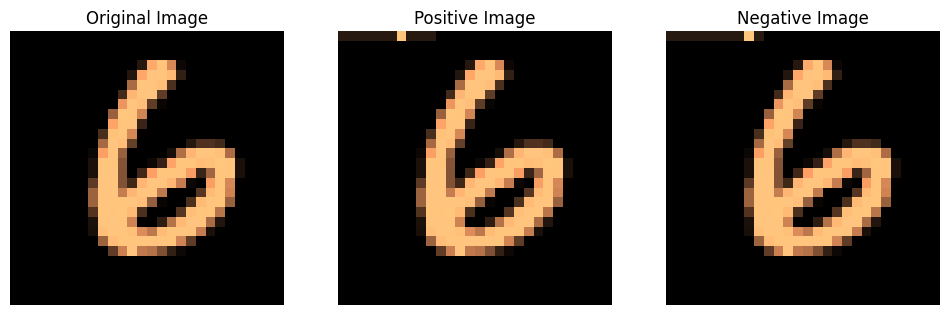

In [8]:
# Visualize original, positive, and negative data

def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].cpu().reshape(28, 28)    ## Reshape the data for display
    plt.imshow(reshaped, cmap='copper')           # Display - using the 'copper' colormap
    plt.title(name)                               # set the title of the plot
    plt.axis('off')                               # Turn off axis labels for better visualization
#-------------------------------------------------------------------------------
plt.figure(figsize=(12, 4))                       # Set the figure size to accommodate three images in one row
#-------------------------------------------------------------------------------
# Iterate over the three sets of data and names
for i, (data, name) in enumerate(zip([x_train, x_pos, x_neg], ['Original Image', 'Positive Image', 'Negative Image'])):
    plt.subplot(1, 3, i+1)                        # creating a subplot for each image in a 1x3 grid
    visualize_sample(data, name)

plt.show()

--------------------------------------------------------------------------------

# **(ج)**

# ***پیاده سازی شبکه***

--------------------------------------------------------------------------------
--- First of all --- about loss function

explanation about the **loss function** which is given in this part of the question:

The given loss function is a form of **binary cross-entropy loss**, commonly used in binary classification problems. It is often applied in logistic regression and neural networks where the goal is to classify instances into two classes: **positive** and **negative**.

$loss = mean(log(1 + exp(threshold - positive_data))) + mean(log(1 + exp(negative_data - threshold)))$

the question in our homework2 : Explain why the above definition of loss can satisfy the necessary conditions of goodness ?

threshold is a decision boundary, and positive_data and negative_data are the model's predictions for positive and negative instances, respectively.

The logarithmic transformation ensures that the loss is large when the predicted probability diverges from the true label. It penalizes the model more for confidently incorrect predictions.

The use of the exponential function in the loss function is common in logistic regression. It ensures that the loss grows rapidly as the predicted probability deviates from the true label.

The mean function calculates the average loss over the entire batch. This makes the loss independent of the size of the batch and allows for easier comparison between different batches.

In summary, the given loss function is designed to strike a balance between penalizing misclassifications, encouraging confidence in correct predictions, and handling the asymmetry between positive and negative instances in a binary classification setting. These characteristics contribute to the effectiveness of the loss function in guiding the learning process of a neural network for binary classification tasks.

--------------------------------------------------------------------------------

In [9]:
class FFLayer(Linear):                      # Defining a custom neural network layer that inherits from pytorch linear layer
    def __init__(
        self                           ,
        in_features : int              ,
        out_features: int              ,
        activation  : Module    = ReLU ,    # Activation function - ReLU
        optimizer   : Optimizer = None ,    # Optimizer for updating weights (default is Adam)
        threshold   : float     = 2.0  ,    # Threshold value for loss calculation
        layer_iters : int       = 10   ,    # number of iterations for updating weights
        bias                    = True ,    # include bias in the layer (default is True)
        device                  = None ,    # Device to perform computations on
        dtype                   = None  ):  # data type of the layer

        super().__init__(in_features, out_features, bias, device, dtype) # Call the constructor of the parent class with specified parameters
        self.activation = activation        # Set the activation function

        if optimizer is None:               # Initialize the optimizer
            self.opt = Adam(self.parameters(), lr=0.01)
        else:
            self.opt = optimizer

        self.threshold   = threshold
        self.layer_iters = layer_iters
    #---------------------------------------------------------------------------
    def forward_pass(self, x):             # Define a forward pass through the layer
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)  # normalize input along the second dimension

        '''
        Note !!!!!!

        2----> The number 2 is used as the argument for the p parameter in the norm function.
        It represents the order of the norm, and in this case, it is the L2 norm or Euclidean norm.
        The L2 norm of a vector v is calculated as the square root of the sum of the squares of its elements:
        ||v||₂ = sqrt(v[0]² + v[1]² + ... + v[n-1]²).
        ------------------------------------------------------------------------
        1----> The number 1 is used as the argument for the dim parameter in the norm function.
        It specifies along which dimension the norm should be computed.
        In this case, dim=1 means that the L2 norm is calculated along the second dimension of the input tensor x.
        ------------------------------------------------------------------------
        1e-4----> This is a small value (1e-4) added to the denominator to prevent division by zero.
        It ensures that even if the norm is very small, the division won't lead to numerical issues.
        '''

        # Perform the forward pass through the layer with activation
        return self.activation(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))
    #---------------------------------------------------------------------------
    def forward(self, *input):                                    # define the overall forward pass through the layer

        if self.training:                                         # If the model is in training mode, ensure two inputs (pos and neg) are provided !!!!
            assert len(input) == 2, "Pass both positive and negative input"
            x_pos = input[0]; x_neg = input[1]                    # Extract positive and negative inputs

            for _ in range(self.layer_iters):                     # Iterate through the layer multiple times for weight updates

                # calculation of squared means of the forward pass outputs
                g_pos = self.forward_pass(x_pos).pow(2).mean(1)  #represent the squared means of the forward pass outputs for positive samples
                g_neg = self.forward_pass(x_neg).pow(2).mean(1)  #represent the squared means of the forward pass outputs for negative samples
                # Comput the loss to push positive and negative samples beyond a threshold
                loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
                self.opt.zero_grad()                             #This line clears the gradients of all optimized tensors.
                loss.backward(retain_graph=True)                 # perform backward pass to compute derivatives (not backpropagation) !!!!!!!!!!!!!!!
                self.opt.step()

            x1, x2 = self.forward_pass(x_pos), self.forward_pass(x_neg)
            return x1, x2                        # Return the forward passes for positive and negative samples

        else:                                    # If the model is in evaluation mode, ensure only one pos input is provided
            assert len(input) == 1, "Pass only 1 argument in eval mode"
            r = self.forward_pass(input[0])      # Perform forward pass through the layer
            return r

More Explanation - FFLayer:

I make a custom neural network layer (FFLayer) that inherits from the PyTorch Linear layer. This layer includes additional parameters like activation function, optimizer, threshold, number of layer iterations, and ....

Forward Pass Method Defines a forward pass through the layer. It normalizes the input along the second dimension and then applies the activation function.
The numbers 2, 1, and 1e-4 are parameters used for normalizing the input tensor x along its second dimension (dimension 1). **(more explanation is in multiline comment in the code cell.)**

Forward Method Defines the overall forward pass through the layer. If the model is in *training mode*, it expects two inputs **(positive and negative)** and iteratively updates the weights to minimize a loss related to positive and negative samples. (The variables g_pos and g_neg represent the squared means of the forward pass outputs for positive and negative samples, respectively.) If in *evaluation mode*, it expects only one input **(positive)** and performs a regular forward pass through the layer.

**in the calculation of the loss function, the goal is to push the squared means of positive samples (g_pos) towards a lower value and the squared means of negative samples (g_neg) towards a higher value, with respect to a specified threshold.**



In [10]:
class FFNet(torch.nn.Module):                           # This neural network composed of multiple FFLayers - inheriting from torch.nn.Module
    def __init__(self, dims):
        super().__init__()                              # Call the constructor of the parent class (Module)
        assert len(dims) >= 1, "len(dims) should be greater than equal to 1"    # to make sure at least there is one layer

        for d in range(len(dims) - 1):                  # Create FFLayer instances for each specified layer dimension
            self.add_module(str(d), FFLayer(dims[d], dims[d + 1], torch.nn.ReLU()))   #Adds each layer as a module to the network. activation f : relu

    def __len__(self) -> int:                           # the length of the network (number of modules)
        return len(self._modules)

    def __dir__(self):                                  #Directory # the available attributes and methods of the network
        keys = super().__dir__()
        keys = [key for key in keys if not key.isdigit()]
        return keys

    def __iter__(self) -> Iterator[Module]:              # an iterator over the modules of the network
        return iter(self._modules.values())

    def forward(self, *input):                           # the forward pass through the network . it handles both training and evaluation modes !!1!

        # If the model is in training mode Iterates through each layer, performing the forward pass on both positive -x_pos- and negative -x_neg- inputs.
        if self.training:
            x_pos, x_neg = input[0]                      #  both positive and negative inputs, and the device are provided
            device = input[1]
            x_pos = x_pos.to(device)
            x_neg = x_neg.to(device)

            for i, module in enumerate(self.children()): # Iterate through each layer in the network
                x_pos, x_neg = module(x_pos, x_neg)      # Perform forward pass through the current layer
            return                                       # eeturn nothing (used for training)

        else:
            assert len(input) == 1, "Only pass the input data "   # If the model is in evaluation mode, only one input should be provided
            for module in self:                          # Iterate through each layer in the network
                input = module(input)                    # performm  forward pass through the current layer
            return input                                 # Return  the final output



I've implemented a neural network architecture for classification using PyTorch. The architecture consists of custom layers (FFLayer) with specific functionalities such as a forward pass with activation, gradient updates, and a unique loss function for positive and negative samples.

In my implementation, the ffLayer is designed to enforce a certain threshold on the squared mean of forward pass outputs during training. This design aims to separate positive and negative samples effectively. The network classes incorporate these layers.



In [11]:
def plot_errors(training_errors, testing_errors, EPOCHS):
    plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot wider
    plt.plot(range(1, EPOCHS + 1), training_errors, label="Training Error", color = 'purple')  # Use training_errors instead of errors
    plt.plot(range(1, EPOCHS + 1), testing_errors , label="Testing Error" , color = 'pink')  # Use testing_errors instead of errors
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.title("Error over Epochs")
    plt.legend()
    plt.xticks(range(1, EPOCHS + 1))  # Set x-axis tick labels to 1, 2, ...
    plt.savefig("error_plot_30_epochs.png")  # Save the plot as a PNG file
    plt.show()

def plot_acc(training_errors, testing_errors , EPOCHS):
    training_accuracies = [1 - error for error in training_errors]
    testing_accuracies = [1 - error for error in testing_errors]
    plt.figure(figsize=(10, 6))  # Adjust the figsize to make the plot wider
    plt.plot(range(1, EPOCHS + 1), training_accuracies, label="Training Accuracy", color='green')
    plt.plot(range(1, EPOCHS + 1), testing_accuracies, label="Testing Accuracy", color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()
    plt.xticks(range(1, EPOCHS + 1))  # Set x-axis tick labels to 1, 2, ...
    plt.savefig("accuracy_plot_30_epochs.png")  # Save the plot as a PNG file
    plt.show()

**plot_errors(training_errors, testing_errors, EPOCHS) function:**

This function is for plotting the training and testing errors over epochs.
The x-axis represents epochs (from 1 to the specified number of epochs), and the y-axis represents errors.
The plot is then saved as a PNG file named "error_plot_30_epochs.png," and the plot is displayed.

**plot_acc(training_errors, testing_errors, EPOCHS) function:**

This function is similar to plot_errors, but it plots training and testing accuracy instead of errors. (accuracy = 1 - error)


In [12]:
# Additional explanations about this functions can be found in the cell below this comment.#
############################################################################################

def training_loop(model, iterator, device):           # the training loop for the neural network
    model.train()                                     #It sets the model to training mode using .train()
    if batched_per_layer:                             # if using batched_per_layer, directly pass the iterator to the model
        model(iterator, device)
    else:
        model.to(device)
        for _, x_data in tqdm(enumerate(iterator)):   # Loop through the data iterator
            model(x_data, device)


def test_loop(model, data_loader, device):            # the testing loop for the neural network
    model.eval()                                      #This linesets the model to evaluation mode using .eval()
    batch_error = 0
    for x, y in data_loader:                          # Loop through the test data loader
        x = x.to(device)
        y = y.to(device)
        #It loops through the test data loader, calculates the error using the calc_error function, and prints the average error
        batch_error += calc_error(model, x, y, device) # Accumulate error using the calc_error function

    avg_error = batch_error / len(data_loader)         # Calculate average error and print it
    avg_accuracy  = 1 - avg_error                          # Accuracy = 1 − Error Rate
    print(f"error: {avg_error}")
    print(f"Accuracy: {avg_accuracy}")
    return avg_error


def eval_loop(model, input, device, batched_per_layer=False): #the evaluation loop for the neural network
    """
    eval_loop(
        model            -> nn.Module model
        input            -> tensor input for eval
        device           -> torch.device
        bached_per_layer -> False by default, if true then load each layer sequentially on device and store the output
        (It is the boolean flag)
    )
    """
    # The "goodness" is calculated as the squared mean of the output for each label. The label with the highest goodness is chosen.

    if batched_per_layer == True:                               #If batched_per_layer is True, the code enters this block.
        goodness_per_label = []                                 # nitializes an empty list goodness_per_label to store the goodness values for each label.
        for label in range(10):                                 #It then iterates over each label in the range [0, 10)
            h = put_y_on_x(input, label)                        #it calls a function put_y_on_x with input and label as arguments,
                                                                # which returns a modified version of input where the label is placed on top of it.
            goodness = []                                       #initializes an empty list -goodness- and iterates over the child modules of the model
            for module in model.children():
                module.to(device)                               #moves the module to the specified device
                h = module(h)
                goodness += [h.pow(2).mean(1)]
                module.to("cpu")                                #After iterating, it moves the module back to the CPU.
            goodness_per_label += [sum(goodness).unsqueeze(1)]  #It appends the sum of all the goodness to the goodness_per_label list
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)                     #returns the label with the highest goodness value using argmax(1).

    else:                                                       #If batched_per_layer is False, the code goes here
     #this part of code follows a similar logic as the previous block, except it moves the entire model to the specified device before the loop.
        model.to(device)
        goodness_per_label = []
        for label in range(10):
            h = put_y_on_x(input, label)
            goodness = []
            for module in model.children():
                h = module(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)


def calc_error(model, x, y, device) -> float:                                   # returning a measure of misclassification rate
    model.eval()
    return (1- eval_loop(model, x, device, batched_per_layer=batched_per_layer).eq(y).float().mean().item())
    # The misclassification rate is computed by taking the mean of the element-wise inequality (eq(y)),
    # converting the result to float, subtracting it from 1, and returning it as a float value.

Explanation about cell above :

In the provided code, a  set of functions for training, testing, and evaluating a neural network  is presented.

**Training Loop (training_loop):**
The training_loop function is designed for training a neural network. It sets the model to training mode, allowing it to learn from the data. If the batched_per_layer flag is enabled, it directly passes the data iterator to the model. Otherwise, it iterates through the data loader, transferring batches to the specified device, and updating the model.

**Testing Loop (test_loop):**
The test_loop function evaluates the performance of the trained model on a test dataset. It sets the model to evaluation mode, iterates through the test data loader, calculates the error using the calc_error function, and prints the average error and accuracy. The accuracy is computed as 1 minus the average error rate.

**Evaluation Loop (eval_loop):**
The eval_loop function performs evaluation on a given input using the trained model. It calculates the "goodness" for each label, considering the squared mean of the output. The label with the highest goodness is chosen. The function supports both standard and batched evaluation modes.

**Error Calculation (calc_error):**
The calc_error function calculates the misclassification rate for a given input and target labels. It utilizes the eval_loop function **to obtain predictions from the model and compares them with the true labels**. The result is a float value representing the misclassification rate.

In summary, these functions provide aframework for training, testing, and evaluating a neural network, with detailed consideration for different evaluation scenarios and the calculation of accuracy and error rates. I try to do my best for efficiently handling data on specified devices.


--------------------------------------------------------------------------------

# **(د)**

# ***گزارش نتایج***

Part D asks for details and explanations of the all parts of implementation. I have provided all the necessary details in each part using single-line comments, multi-line comments, markdowns, and text cells placed below the code cells.

In [13]:
# Define parameters
EPOCHS = 30
BATCH_SIZE = 1000
TRAIN_BATCH_SIZE = BATCH_SIZE
TEST_BATCH_SIZE = BATCH_SIZE
batched_per_layer = False
'''
These lines define parameters for the training process. EPOCHS specifies the number of training epochs, BATCH_SIZE
is the batch size used for both training and testing, TRAIN_BATCH_SIZE and TEST_BATCH_SIZE store the same value
as BATCH_SIZE, and batched_per_layer is a boolean flag indicating whether to load each layer sequentially during evaluation.
'''

# Build train and test loaders
train_loader, test_loader = data_loaders(train_batch_size=TRAIN_BATCH_SIZE, test_batch_size=TEST_BATCH_SIZE)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Build network
net = FFNet([784, 2000,2000,2000,2000, 10])
'''
This line creates an instance of the FFNet class, which represents a feed-forward neural network.
The network architecture is specified as a list of layer sizes: [784, 2000, 2000, 2000, 2000, 10].
This indicates a network with an input size of 784, four hidden layers with 2000 units each, and an output layer with 10 units.
(as said in the refrence paper)
'''

training_errors = []                          # empty list
testing_errors  = []                          # empty list

# Iterator in place of DataLoader
data_iter = []                                # empty list

# Encode true and false labels on images to create positive and negative data
print("Encoding positive and negative data with correct and incorrect labels")
for x, y in tqdm(train_loader):
    x_pos, x_neg = None, None
    x_pos = put_y_on_x(x, y)
    rand_mask = torch.randint(0, 9, y.size())
    y_rnd = (y + rand_mask + 1) % 10
    x_neg = put_y_on_x(x, y_rnd)

    ''' I did this part in a different way in part B earlier. I think here I write it in a better way'''

    data_iter.append((x_pos, x_neg))

Using device: cuda
Encoding positive and negative data with correct and incorrect labels


100%|██████████| 60/60 [00:13<00:00,  4.36it/s]


In [14]:
for epoch in range(EPOCHS):
    print(f"---------------------- EPOCH: {epoch} ----------------------")
    start = time.time()
    print("Training ...")
    training_loop(net, data_iter, device)
    print("\nevaluate training data:")
    training_error = test_loop(net, train_loader, device)
    training_errors.append(training_error)
    print("\nevaluate test data:    ")
    testing_error = test_loop(net, test_loader, device)
    testing_errors.append(testing_error)
    end = time.time()
    elapsed = end - start


---------------------- EPOCH: 0 ----------------------
Training ...


60it [01:12,  1.21s/it]



evaluate training data:
error: 0.24851663410663605
Accuracy: 0.751483365893364

evaluate test data:    
error: 0.24369996190071105
Accuracy: 0.7563000380992889
---------------------- EPOCH: 1 ----------------------
Training ...


60it [01:12,  1.20s/it]



evaluate training data:
error: 0.1334499607483546
Accuracy: 0.8665500392516454

evaluate test data:    
error: 0.12489995956420899
Accuracy: 0.875100040435791
---------------------- EPOCH: 2 ----------------------
Training ...


60it [01:11,  1.19s/it]



evaluate training data:
error: 0.10474995871384939
Accuracy: 0.8952500412861506

evaluate test data:    
error: 0.10109996199607849
Accuracy: 0.8989000380039215
---------------------- EPOCH: 3 ----------------------
Training ...


60it [01:10,  1.18s/it]



evaluate training data:
error: 0.0928332914908727
Accuracy: 0.9071667085091273

evaluate test data:    
error: 0.09119994640350342
Accuracy: 0.9088000535964966
---------------------- EPOCH: 4 ----------------------
Training ...


60it [01:10,  1.17s/it]



evaluate training data:
error: 0.08161662419637045
Accuracy: 0.9183833758036295

evaluate test data:    
error: 0.07959995865821838
Accuracy: 0.9204000413417817
---------------------- EPOCH: 5 ----------------------
Training ...


60it [01:10,  1.17s/it]



evaluate training data:
error: 0.07559995452562968
Accuracy: 0.9244000454743704

evaluate test data:    
error: 0.07579994797706605
Accuracy: 0.924200052022934
---------------------- EPOCH: 6 ----------------------
Training ...


60it [01:10,  1.17s/it]



evaluate training data:
error: 0.07071662247180939
Accuracy: 0.9292833775281906

evaluate test data:    
error: 0.06829995512962342
Accuracy: 0.9317000448703766
---------------------- EPOCH: 7 ----------------------
Training ...


60it [01:09,  1.16s/it]



evaluate training data:
error: 0.06716662545998892
Accuracy: 0.932833374540011

evaluate test data:    
error: 0.06519995331764221
Accuracy: 0.9348000466823578
---------------------- EPOCH: 8 ----------------------
Training ...


60it [01:09,  1.16s/it]



evaluate training data:
error: 0.06349995235602061
Accuracy: 0.9365000476439794

evaluate test data:    
error: 0.06269996166229248
Accuracy: 0.9373000383377075
---------------------- EPOCH: 9 ----------------------
Training ...


60it [01:09,  1.16s/it]



evaluate training data:
error: 0.060616620381673175
Accuracy: 0.9393833796183269

evaluate test data:    
error: 0.06189994812011719
Accuracy: 0.9381000518798828
---------------------- EPOCH: 10 ----------------------
Training ...


60it [01:09,  1.16s/it]



evaluate training data:
error: 0.057349958022435504
Accuracy: 0.9426500419775645

evaluate test data:    
error: 0.05989995002746582
Accuracy: 0.9401000499725342
---------------------- EPOCH: 11 ----------------------
Training ...


60it [01:09,  1.15s/it]



evaluate training data:
error: 0.05536661942799886
Accuracy: 0.9446333805720012

evaluate test data:    
error: 0.05889995694160462
Accuracy: 0.9411000430583953
---------------------- EPOCH: 12 ----------------------
Training ...


60it [01:09,  1.15s/it]



evaluate training data:
error: 0.052866620818773906
Accuracy: 0.9471333791812261

evaluate test data:    
error: 0.057599955797195436
Accuracy: 0.9424000442028045
---------------------- EPOCH: 13 ----------------------
Training ...


60it [01:08,  1.15s/it]



evaluate training data:
error: 0.04999995430310567
Accuracy: 0.9500000456968943

evaluate test data:    
error: 0.05579996109008789
Accuracy: 0.9442000389099121
---------------------- EPOCH: 14 ----------------------
Training ...


60it [01:08,  1.15s/it]



evaluate training data:
error: 0.047966622312863666
Accuracy: 0.9520333776871364

evaluate test data:    
error: 0.0535999596118927
Accuracy: 0.9464000403881073
---------------------- EPOCH: 15 ----------------------
Training ...


60it [01:08,  1.15s/it]



evaluate training data:
error: 0.046749956409136456
Accuracy: 0.9532500435908635

evaluate test data:    
error: 0.05409995317459106
Accuracy: 0.945900046825409
---------------------- EPOCH: 16 ----------------------
Training ...


60it [01:08,  1.15s/it]



evaluate training data:
error: 0.0460166205962499
Accuracy: 0.9539833794037501

evaluate test data:    
error: 0.05369995236396789
Accuracy: 0.9463000476360321
---------------------- EPOCH: 17 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.045883290966351825
Accuracy: 0.9541167090336482

evaluate test data:    
error: 0.05369996428489685
Accuracy: 0.9463000357151031
---------------------- EPOCH: 18 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.045399951934814456
Accuracy: 0.9546000480651855

evaluate test data:    
error: 0.05399995446205139
Accuracy: 0.9460000455379486
---------------------- EPOCH: 19 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.04478328724702199
Accuracy: 0.955216712752978

evaluate test data:    
error: 0.053699958324432376
Accuracy: 0.9463000416755676
---------------------- EPOCH: 20 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.0430166224638621
Accuracy: 0.9569833775361379

evaluate test data:    
error: 0.05269995927810669
Accuracy: 0.9473000407218933
---------------------- EPOCH: 21 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.04209995667139689
Accuracy: 0.9579000433286031

evaluate test data:    
error: 0.05069995522499084
Accuracy: 0.9493000447750092
---------------------- EPOCH: 22 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.0408499538898468
Accuracy: 0.9591500461101532

evaluate test data:    
error: 0.04999996423721313
Accuracy: 0.9500000357627869
---------------------- EPOCH: 23 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.03964995443820953
Accuracy: 0.9603500455617905

evaluate test data:    
error: 0.04859995245933533
Accuracy: 0.9514000475406647
---------------------- EPOCH: 24 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.039033288757006325
Accuracy: 0.9609667112429937

evaluate test data:    
error: 0.048699957132339475
Accuracy: 0.9513000428676606
---------------------- EPOCH: 25 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.039233288168907164
Accuracy: 0.9607667118310929

evaluate test data:    
error: 0.048499959707260135
Accuracy: 0.9515000402927398
---------------------- EPOCH: 26 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.03853328625361125
Accuracy: 0.9614667137463887

evaluate test data:    
error: 0.04729995131492615
Accuracy: 0.9527000486850739
---------------------- EPOCH: 27 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.03838328719139099
Accuracy: 0.961616712808609

evaluate test data:    
error: 0.046599960327148436
Accuracy: 0.9534000396728516
---------------------- EPOCH: 28 ----------------------
Training ...


60it [01:08,  1.13s/it]



evaluate training data:
error: 0.038016624252001446
Accuracy: 0.9619833757479985

evaluate test data:    
error: 0.04619996547698975
Accuracy: 0.9538000345230102
---------------------- EPOCH: 29 ----------------------
Training ...


60it [01:08,  1.14s/it]



evaluate training data:
error: 0.03738328715165456
Accuracy: 0.9626167128483455

evaluate test data:    
error: 0.04599995613098144
Accuracy: 0.9540000438690186


this block defines various parameters such as the number of epochs, batch sizes, and encoding method.
Creates an instance of the neural network (FFNet) with a specified architecture.
Iterates through the specified number of epochs, performing training and testing at each epoch. The training and testing errors are stored and plotted using the previously defined functions (plot_errors).


more explanation about training error and test error :

it is acceptable for the test error and train error to be relatively close in value. When training a model, the goal is to minimize the error on both the training and testing datasets. If the model performs well on the training data but poorly on the testing data, it may show overfitting, where the model has memorized the training data too well and fails to generalize to unseen data.

Having similar error values for the training and testing datasets (which we hhave here) suggests that the model is not overfitting and is learning general patterns from the training data that can be applied to the testing data.

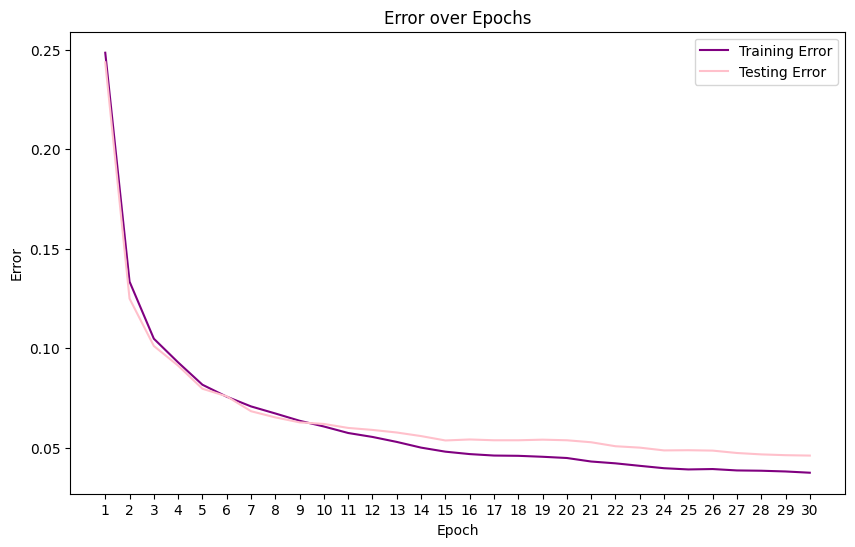

In [15]:
# Plot errors
plot_errors(training_errors, testing_errors, EPOCHS)

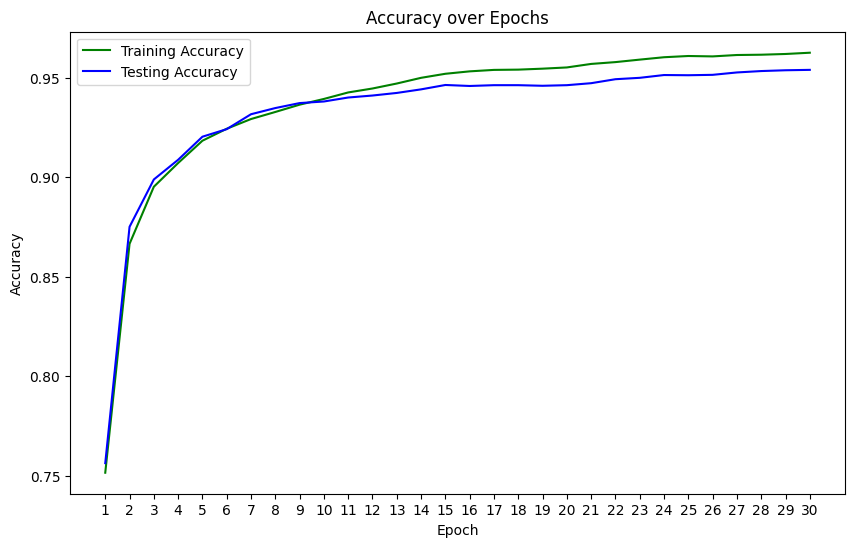

In [16]:
plot_acc(training_errors, testing_errors, EPOCHS)

For the **Unsupervised Forward-Forward Algorithm** please check the other notebook in this repository.

**Thank you for your attention**